In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [3]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "!    total energy" in match]
    KS_te = str(k).split()[4]
    KS_TE.append(float(KS_te)) 
ks_te = np.asarray(KS_TE)

In [4]:
def min_energy(x0, *args):
        KS_TE, rho, ions = args
        KE = Functional(type='KEDF',name='WT', rho0=x0)
        grid = DirectGrid(lattice=ions.cell, nr=[len(rho),len(rho),len(rho[0,0])])
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        OF_TE = evaluator.Energy(rho=rho, ions=ions)
        # OF_KE = KE(rho).energy
        diff = np.abs(KS_TE*1/2-OF_TE)
        print(diff)
        return diff

In [5]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
l = np.linspace(0.8, 1.4, 30)
delta_E = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0,1]], options={'ftol' : 1e-1})
    VOLUME = ions.get_volume()
    vol.append(VOLUME)
    delta_E.append(minn.fun)
    R0.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.08506652045527296
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.2972151767393516
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.3541317471614942
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.22193800172704137
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.1309812314639789
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.029855990491066464
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.03173559169406026
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0043178202164835255
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.005910486703948337
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0025646442217652776
setting key: Si -> /Use

In [6]:
R0

[array([0.07665087]),
 array([0.07042939]),
 array([0.05603113]),
 array([0.05818341]),
 array([0.04927457]),
 array([0.04696348]),
 array([0.02116962]),
 array([0.02748302]),
 array([0.03816746]),
 array([0.03649436]),
 array([0.03489619]),
 array([0.03343089]),
 array([0.03212502]),
 array([0.03096562]),
 array([0.02994185]),
 array([0.02904396]),
 array([0.0282518]),
 array([0.02754698]),
 array([0.02691576]),
 array([0.02634504]),
 array([0.02582177]),
 array([0.02533628]),
 array([0.02488212]),
 array([0.02445452]),
 array([0.02404981]),
 array([0.02366509]),
 array([0.02329841]),
 array([0.02294754]),
 array([0.02261241]),
 array([0.02229284])]

Text(0, 0.5, '$ρ_{0}$')

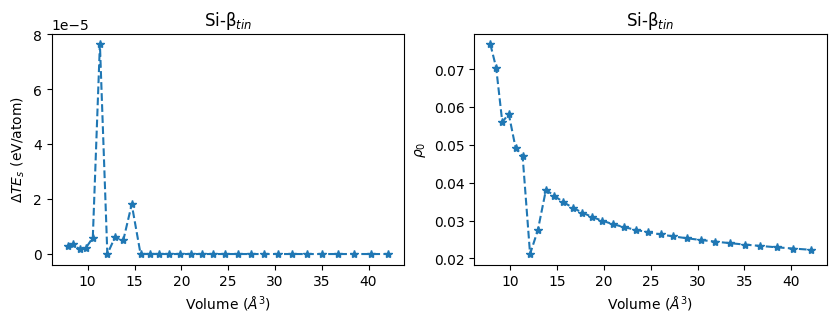

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta TE_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [14]:
delta_E1 = []
R1 = []
vol1 = []
for n in np.arange(0,8,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.039,0.08]], options={'ftol' : 1e-1})
    VOLUME = ions.get_volume()
    vol1.append(VOLUME)
    delta_E1.append(minn.fun)
    R1.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf


/var/folders/9b/gsh5m3sd3j96rq9k2zstrc_40000gn/T/ipykernel_10875/1360534059.py:12: OptimizeWarning: Initial guess is not within the specified bounds
  minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.039,0.08]], options={'ftol' : 1e-1})


0.08506652045527296
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.03402225841082718
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0015260001928414368
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.009293794299155778
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00340492351414845
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.01780428726995531
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.007161586518590113
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0016745657594281482
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0003031538644275855
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0008162209144071397
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00013493845318457431
setting

In [11]:
len(rho0[0:7])

7

In [15]:
rho0 = np.asarray(R0)
rho0[0:8] = np.asarray(R1)
d_E = np.asarray(delta_E)
d_E[0:8] = np.asarray(delta_E1)

Text(0, 0.5, '$ρ_{0}$')

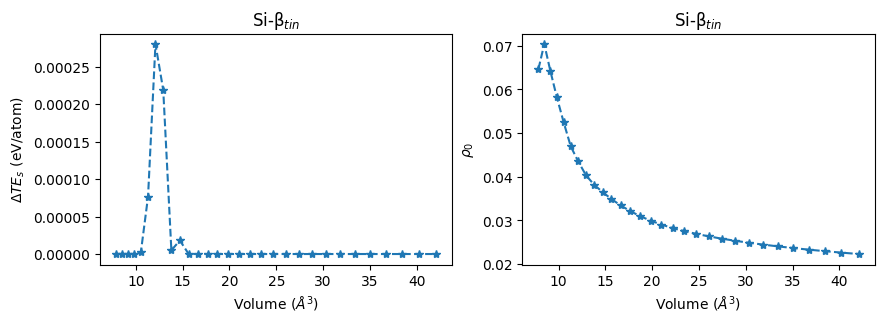

In [16]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(d_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(rho0),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta TE_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [17]:
np.asarray(rho0)

array([[0.06465835],
       [0.07042192],
       [0.0641929 ],
       [0.0581888 ],
       [0.05249234],
       [0.04695438],
       [0.04352353],
       [0.04034545],
       [0.03816746],
       [0.03649436],
       [0.03489619],
       [0.03343089],
       [0.03212502],
       [0.03096562],
       [0.02994185],
       [0.02904396],
       [0.0282518 ],
       [0.02754698],
       [0.02691576],
       [0.02634504],
       [0.02582177],
       [0.02533628],
       [0.02488212],
       [0.02445452],
       [0.02404981],
       [0.02366509],
       [0.02329841],
       [0.02294754],
       [0.02261241],
       [0.02229284]])

In [19]:
delta_E2 = []
R2 = []
vol2 = []
for n in np.arange(0,1,1):
    print('NEW STRUCTURE')
    print(n)
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.07,0.09]], options={'ftol' : 1e-1})
    VOLUME = ions.get_volume()
    vol2.append(VOLUME)
    delta_E2.append(minn.fun)
    R2.append(minn.x)

NEW STRUCTURE
0
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf


/var/folders/9b/gsh5m3sd3j96rq9k2zstrc_40000gn/T/ipykernel_10875/3629764077.py:13: OptimizeWarning: Initial guess is not within the specified bounds
  minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.07,0.09]], options={'ftol' : 1e-1})


0.08506652045527296
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0019415301519796202
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.012064015834065245
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0035484298832688665
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0005924745822074584
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0004492145115850832
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00011345361093084705
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
2.5564049623838514e-05
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00024122265285875244
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
3.8898097637130036e-05
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
9.012695129761994e-

In [25]:
rho01 = np.asarray(rho0)
rho01[0] = np.asarray(R2)
d_E1 = np.asarray(d_E)
d_E1[0] = np.asarray(delta_E2)

Text(0, 0.5, '$ρ_{0}$')

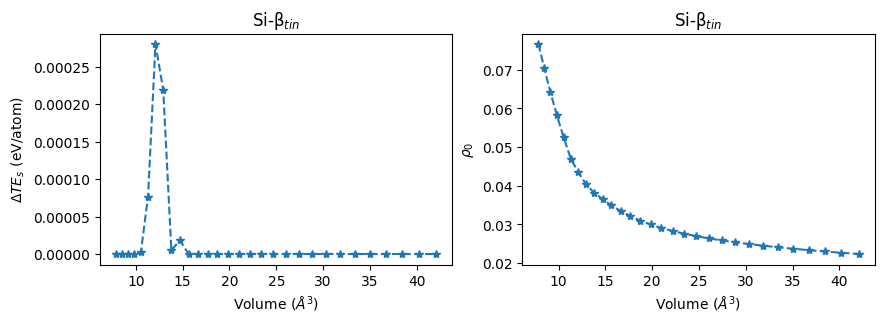

In [26]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(d_E1)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(rho01),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta TE_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [27]:
np.save('/DATA2/rho0_dTE', np.asarray(rho01))